# Data harmoinsation in imaging - the problem
This notebook will give a brief example of how differences can arise when acquiring data using multiple scanners in a study. For more background on this, please see the documenation web pages. 

To illistrate this probelm, let's take a scenario where we expect the least amount of change. We will jave a hjealthy subejct scanned on two different scanners. We will register them together and see if there are any differences present. if the scans produced were truly quantitiave, then we would expect to see a minimal difference between the scans save for a bit of measurement error. 

## Setup
To start with, we will import a few basic packages and setup the notebook to have interactive content (the matplotlib widget *magic* command in Jupyter)

In [1]:
import os
import shutil
import matplotlib
%matplotlib widget

## Getting the data
For this demonstration, I used [Datalad](https://www.datalad.org/) to setup the data repository. Datalad is built upon git and git-annex, and it provides version control for data management, data sharing and reproducible science. For this lesson, it offers us a convenient way of grabbing the data that we need. These comamands import datalad so that we can use it to clone the repository into our virtual machine.

In [2]:
import nest_asyncio
nest_asyncio.apply()

In [3]:
import datalad.api as dl

Next we "clone" the repository to a local destination. No big files are downloaded yet, just the metadata so this computer know what data exists.

In [4]:
dl_source='https://github.com/HealthBioscienceIDEAS/demon-imaging-data.git'
sample=dl.clone(dl_source,path='/tmp/sample',description='Cloned sample dataset for import')
sample.update(merge=True)
sample.siblings(action='enable',name='demons-data')

[INFO] Fetching updates for Dataset(/tmp/sample) 


.: demons-data(?) [git]


[{'action': 'enable-sibling',
  'path': '/tmp/sample',
  'type': 'sibling',
  'name': 'demons-data',
  'refds': '/tmp/sample',
  'status': 'ok'}]

Now we get our first and second image from the same individual using the datalad get command. Big data is not downloaded automaticaly, only as it is needed, saving valuable space, especially on large repositories. If not downloaded before, then this might take a few seconds on the binder instance, so be patient. When it is running, the number to the left becomes a star. When it is complete, it becomes a number again.

In [5]:
bl_img=sample.get('./baseline_t1.nii.gz')

In [6]:
fu_img=sample.get('./followup_t1.nii.gz')

# Intrasubject registration
The python package [nipype](https://nipype.readthedocs.io/en/latest/index.html) provides an effective means in Python to run your image processing workflows, taking "building blocks" of individual commands, allowing you to piece together bits of various software packages (FSL, SPM, FreeSurfer, AFNI, MRtrix, etc) into complete pipelines. We are just going to use it for simple cases here by registereing our baseline and followup image.

In [8]:
from nipype.interfaces import niftyreg


This sets up the node that will run rigid registration using  [NiftyReg](https://github.com/KCL-BMEIS/niftyreg), a lightweight easy to use registration package. We set the inputs and outputs up, and it will generate the command line, which you can see below.

In [9]:
out_path=os.path.join(os.getcwd(),'results')
if not os.path.exists(out_path):
    os.makedirs(out_path)
followup_aff=os.path.join(out_path,'followup_to_baseline_aff.txt')
followup_res=os.path.join(out_path,'followup_t1_resampled.nii.gz')
node = niftyreg.RegAladin(verbosity_off_flag=True)
node.inputs.ref_file = bl_img[0]['path']
node.inputs.flo_file = fu_img[0]['path']
node.inputs.aff_file = followup_aff
node.inputs.res_file = followup_res
node.cmdline

'reg_aladin -aff /Users/davecash/src/demon-imaging-harmonisation/results/followup_to_baseline_aff.txt -flo /tmp/sample/followup_t1.nii.gz -omp 1 -ref /tmp/sample/baseline_t1.nii.gz -res /Users/davecash/src/demon-imaging-harmonisation/results/followup_t1_resampled.nii.gz -voff'

If we are happy with that, then we run the code. This might take a little while, as nipype doesn't produce the output until it is all complete. 

In [10]:
node.run()

210910-12:20:30,317 nipype.interface INFO:
	 stdout 2021-09-10T12:20:30.316921:[NiftyReg WARNING] NiftyReg has not been compiled with OpenMP, the '-omp' flag is ignored


It has now generated the affine transformation between the two images and ar esampled followup image. You can now see these in the results directory of your drive and the next step will put the baseline there to, so that you can compare them on your own macine if you prefer. 

In [12]:
baseline_nii=os.path.join('baseline_t1.nii.gz')
shutil.copyfile(bl_img[0]['path'],baseline_nii)

'baseline_t1.nii.gz'

## Checking the registration

The registration means that both images should be in the same space. If you go back to the tree view in Binder, you can see these files, download them and examine the in your favorite local viewier. Or you can look at them through this noteboook below using a lightweight 3D slice viewer called [nanslice](https://github.com/spinicist/nanslice).

In [13]:
import nanslice.jupyter as ns

Let's first ook at both the baseline and registered followup images separately.  

In [15]:
ns.three_plane(baseline_nii,cbar=True,interactive=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [16]:
ns.three_plane(followup_res,cbar=True,interactive=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Notice how the contrast looks different between the two images. Also the intensity scales are quite off. 

In [13]:
base=ns.Layer(bl_img[0]['path'],cmap='Purples_r',clim=(50,312),
              alpha=os.path.join(out_path,'baseline_t1_bin.nii.gz'),alpha_lim=(0,0.5))
reg=ns.Layer(node.inputs.res_file,cmap='Greens_r',alpha=os.path.join(out_path,'followup_res_bin.nii.gz'),alpha_lim=(0,0.5))
ns.three_plane(reg,title="overlay",cbar=True,interactive=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

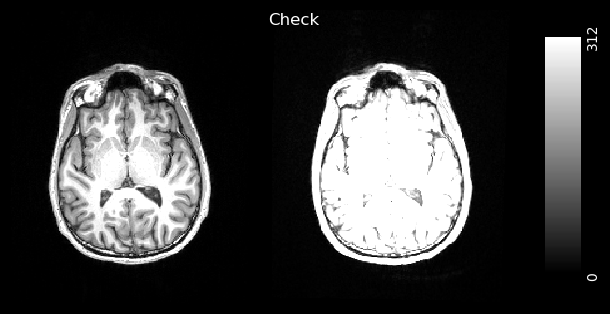

In [31]:
ns.compare(bl_img[0]['path'],node.inputs.res_file,title='Check')